In [11]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

from nltk.stem import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.constraints import maxnorm

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

### Modelling
The baseline is going to be taken as a basic neural net, with 1 hidden layer and dropout. Keras is used to build and train the model
First though, we need to re-define the input features. Keeping each of the 25 headlines seperate gives almost 400,000 features which gives too high a computational burden. Instead, all headlines will be merged to give a single document per date. Since we're using a bag of words approach this should have negligible impact - our prediction will be based on the presence of a small set of keywords which should perform the same even with the headlines merged

In [2]:
# Set seed
seed = 1984
np.random.seed(seed)

In [3]:
# Load training data
train = pd.read_csv("Datasets/Combined_News_DJIA_train.csv")
train.shape

(1611, 28)

In [4]:
# First correct the nan records in the training data
train.set_value(277, 'Top23', "NA")
train.set_value(277, 'Top24', "NA")
train.set_value(277, 'Top25', "NA")
train.set_value(348, 'Top24', "NA")
train.set_value(348, 'Top25', "NA")
train.set_value(681, 'Top24', "NA")
train.set_value(681, 'Top25', "NA")
train['Top23'][277]

'NA'

In [5]:
# Combine all headings into a single document per date
#train['Combined'] = " ".join([str(train[x]) for x in train.columns if 'Top' in x])
train['Combined'] = train[[x for x in train.columns if 'Top' in x]].apply(lambda x: ' '.join(x), axis=1)
train.loc[0, 'Combined']

'b"Georgia \'downs two Russian warplanes\' as countries move to brink of war" b\'BREAKING: Musharraf to be impeached.\' b\'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\' b\'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\' b"Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing" b\'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\' b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side" b"The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it." b\'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\' b\'Did the U.S. Prep Georgia for War with Russia?\'

In [6]:
# Build tf-idf term document matrix from this
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')

# Convert to lowercase, stem and lemmatize
ls = LancasterStemmer
wl = WordNetLemmatizer()

doc_list = [" ".join([wl.lemmatize(x.lower()) for x in CountVectorizer().build_tokenizer()(doc)]) for doc in list(train['Combined'])]

print(doc_list[0])

georgia down two russian warplane a country move to brink of war breaking musharraf to be impeached russia today column of troop roll into south ossetia footage from fighting youtube russian tank are moving towards the capital of south ossetia which ha reportedly been completely destroyed by georgian artillery fire afghan child raped with impunity official say this is sick three year old wa raped and they do nothing 150 russian tank have entered south ossetia whilst georgia shoot down two russian jet breaking georgia invades south ossetia russia warned it would intervene on so side the enemy combatent trial are nothing but sham salim haman ha been sentenced to year but will be kept longer anyway just because they feel like it georgian troop retreat from osettain capital presumably leaving several hundred people killed video did the prep georgia for war with russia rice give green light for israel to attack iran say ha no veto over israeli military ops announcing class action lawsuit on

In [7]:
# Split into train and test subsets
Input_y = train['Target']

X_train, X_test, y_train, y_test = train_test_split(
    doc_list, Input_y, test_size=0.33, random_state=42, stratify=Input_y)

print(len(X_train))
print(y_train.shape)

1079
(1079,)


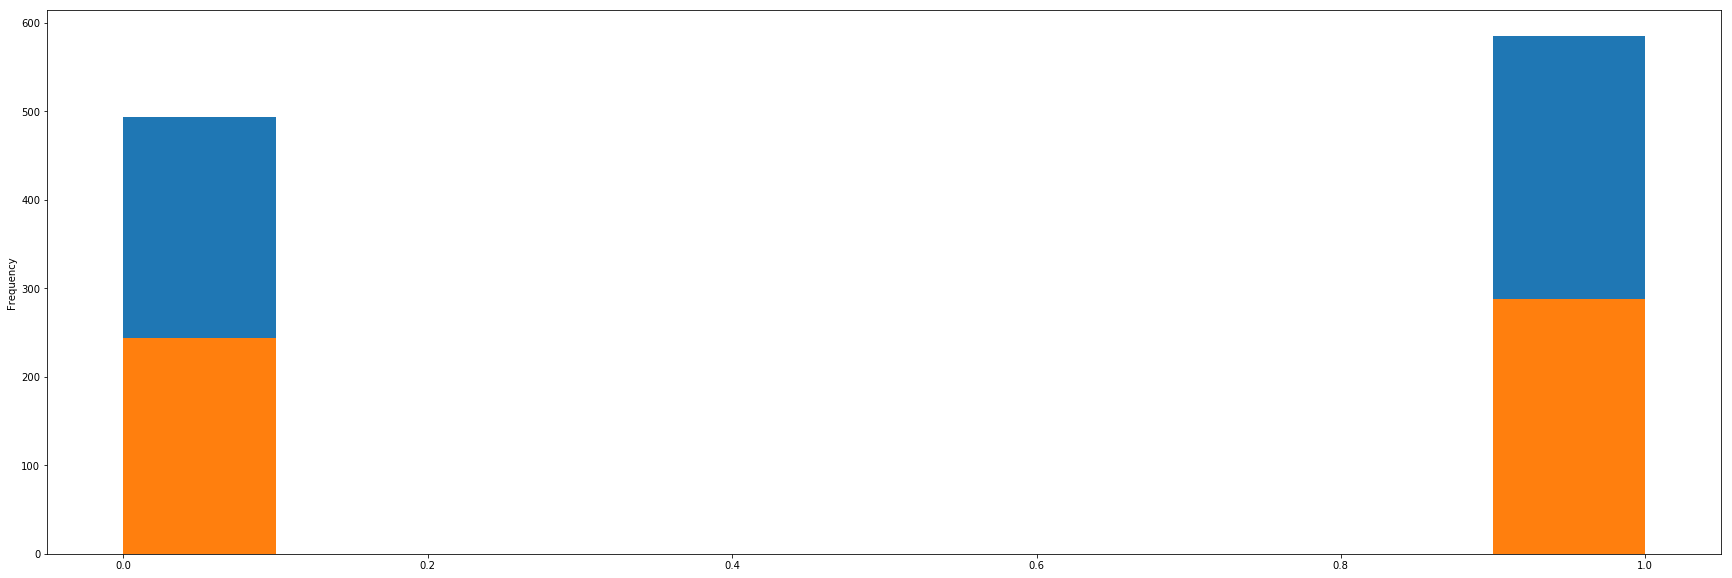

In [8]:
# plot of breakdown of target var on training and test sets
y_train.plot(kind='hist', figsize=[30,10])
y_test.plot(kind='hist', figsize=[30,10])

In [8]:
# Convert to data frame (With dense input matrix)
train_tf_idf = vectorizer.fit_transform(X_train)

vocab = vectorizer.get_feature_names()
train_tdm_df = pd.DataFrame(data=train_tf_idf.todense(), columns=vocab)
train_tdm_df.shape

(1079, 12864)

In [9]:
# Get tf-idf values for test data
X_test = vectorizer.transform(X_test)
test_df = pd.DataFrame(data=X_test.todense(), columns=vocab)
test_df.shape

(532, 12864)

In [11]:
# Fit a model to the training data
width = train_tdm_df.shape[1]
layer_shape = 2000

model = Sequential()
model.add(Dense(width, input_dim=width, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(layer_shape, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

model.fit(train_tdm_df.values, y_train, verbose=0)

In [12]:
# Predict on test set
y_pred = model.predict(test_df.values)

(array([  6.,   6.,   7.,   8.,  11.,  11.,   8.,   9.,   3.,  15.,  21.,
          8.,   9.,   8.,  12.,  13.,   9.,   8.,   5.,   6.,   9.,   7.,
         12.,  10.,   1.,   8.,  13.,  10.,  10.,  12.,   6.,  12.,  13.,
          7.,  16.,  10.,   6.,  14.,   9.,  11.,  12.,   8.,  11.,  15.,
         20.,  23.,  21.,  17.,  19.,   7.]),
 array([ 0.00744311,  0.02726972,  0.04709633,  0.06692294,  0.08674955,
         0.10657616,  0.12640277,  0.14622938,  0.16605599,  0.1858826 ,
         0.20570921,  0.22553582,  0.24536243,  0.26518904,  0.28501566,
         0.30484227,  0.32466888,  0.34449549,  0.3643221 ,  0.38414871,
         0.40397532,  0.42380193,  0.44362854,  0.46345515,  0.48328176,
         0.50310837,  0.52293498,  0.54276159,  0.5625882 ,  0.58241481,
         0.60224142,  0.62206803,  0.64189464,  0.66172126,  0.68154787,
         0.70137448,  0.72120109,  0.7410277 ,  0.76085431,  0.78068092,
         0.80050753,  0.82033414,  0.84016075,  0.85998736,  0.87981397,
 

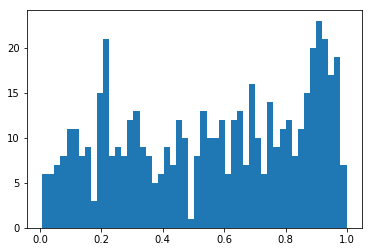

In [13]:
# Histogram of prediction results
plt.hist(y_pred, bins=50)

In [14]:
# Initial hacky approach is to simply take 0.5 as the cutoff for prediction
y_pred_binary = [1 if (x>0.5) else 0 for x in y_pred]
y_pred_binary[0]

0

In [15]:
# Confusion matrix of results
conf = confusion_matrix(y_test, y_pred_binary)
conf

array([[106, 138],
       [116, 172]])

In [16]:
# Test accuracy
correct = sum([conf[i][i] for i in range(len(conf))])
total = sum([sum(x) for x in conf])

correct / total

0.52255639097744366

In [17]:
# Loop over different cutoff values for the binary predictions, comparing the accuracies each time
cutoffs = [0.3 + 0.1*i for i in range(6)]

for c in cutoffs:
    y_pred_binary = [1 if (x>c) else 0 for x in y_pred]
    conf = confusion_matrix(y_test, y_pred_binary)
    correct = sum([conf[i][i] for i in range(len(conf))])
    total = sum([sum(x) for x in conf])
    
    print(c, correct / total)

0.3 0.505639097744
0.4 0.518796992481
0.5 0.522556390977
0.6000000000000001 0.505639097744
0.7 0.494360902256
0.8 0.475563909774


Despite the right skew in the predictions histogram, moving the cutoff had little impact on the accuracy.

Lets try instead a deeper architecture with softmax activations and see how the model performs.
Capture the training accuracy to see if the model is overfitting on the training data

In [28]:
# Fit a model to the training data
width = train_tdm_df.shape[1]

model = Sequential()
model.add(Dense(4000, input_dim=width, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2000, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='softmax'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

hist = model.fit(train_tdm_df.values, y_train, nb_epoch=50, verbose=0)
print("Training results: Accuracy - %.2f% Loss - %.2f%" % (hist.history['acc'][-1], hist.history['loss'][-1]))

In [24]:
# Information captured in history:
hist.history.keys()

dict_keys(['loss', 'acc'])

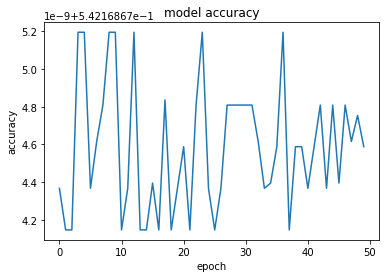

In [29]:
# Accuracy plot
plt.plot(hist.history['acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.show()

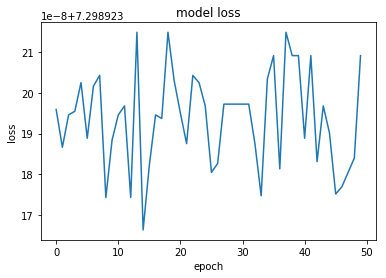

In [30]:
# Log-loss plot
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [31]:
# Predict on test set
y_pred = model.predict(test_df.values)

# Confusion matrix:
conf = confusion_matrix(y_test, y_pred)
print(conf)

# Accuracy
sum([conf[i][i] for i in range(len(conf))]) / sum([sum(x) for x in conf])

[[171  73]
 [206  82]]


0.47556390977443608

In [12]:
# Can a much wider net be trained?
width = train_tdm_df.shape[1]

model = Sequential()
model.add(Dense(width, input_dim=width, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(5000, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(400, activation='relu', W_constraint=maxnorm(3)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='adadelta',
              metrics=['accuracy'])

hist = model.fit(train_tdm_df.values, y_train, nb_epoch=10, verbose=0)
hist.history['acc']

[0.53382761866213324,
 0.54216867458831386,
 0.55792400398333941,
 0.61353104737646824,
 0.66172381862652752,
 0.72567191813917931,
 0.84337349397590367,
 0.98702502339056397,
 1.0,
 1.0]

In [13]:
# Obtain predictions
y_pred = model.predict(test_df.values)

y_pred_binary = [1 if (x>0.5) else 0 for x in y_pred]

conf = confusion_matrix(y_test, y_pred_binary)
print(conf)

# Accuracy
sum([conf[i][i] for i in range(len(conf))]) / sum([sum(x) for x in conf])

[[ 98 146]
 [111 177]]


0.51691729323308266

In [13]:
cutoffs = [0.3 + 0.1*i for i in range(6)]

for c in cutoffs:
    y_pred_binary = [1 if (x>c) else 0 for x in y_pred]
    conf = confusion_matrix(y_test, y_pred_binary)
    correct = sum([conf[i][i] for i in range(len(conf))])
    total = sum([sum(x) for x in conf])
    
    print(c, correct / total)

0.3 0.518796992481
0.4 0.516917293233
0.5 0.526315789474
0.6000000000000001 0.516917293233
0.7 0.496240601504
0.8 0.486842105263


#### K-Fold cross validation
Instead of simply training and testing on 2 distinct splits, use k-fold cross validation to run 10 iterations

In [18]:
# Build tdm of tf-idf values on entire dataset - for kfold cross val
full_tf_idf = vectorizer.fit_transform(doc_list)

vocab = vectorizer.get_feature_names()
full_tdm_df = pd.DataFrame(data=full_tf_idf.todense(), columns=vocab)
full_tdm_df.shape

(1611, 15559)

In [19]:
# Width will be the tdm width
width = full_tdm_df.shape[1]
layer_shape = 2000

# Build basic sequential model
def base_model():
    model = Sequential()
    model.add(Dense(4000, input_dim=width, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(layer_shape, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adadelta',
                  metrics=['accuracy'])
    return model

In [20]:
# Train and evaluate with kfold cross val
estimator = KerasClassifier(build_fn=base_model, nb_epoch=10, batch_size=32, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=seed)
results = cross_val_score(estimator, full_tdm_df.values, Input_y, cv=kfold)
print("Results: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Results: 50.46% (3.29%)


A fraction over 50% isn't ideal (It's basically random chance). More work is going to be needed to get that value higher.
A few things that can be looked at:
* Extract topics using LDA to form the input features
* LSTM to process the headlines (Potentially better for semantic understanding)
* Combine with sequence learning - predict the next target value based on preceeding ones
* Use word embeddings combined with convnet - https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html